### importing icevision for dataset loading and model training and other libraries for coco creation

In [1]:
import numpy as np
import ceruleanml.data as data
import json
import os
from PIL import Image
from pathlib import Path
import skimage as ski

In [2]:
ml_data_path = os.path.join(os.path.abspath(os.getcwd()),"../../data/cerulean_v2_example/")

In [3]:
path = Path(ml_data_path)
layer_pths = list(path.glob("assets_test1_png/*"))

In [4]:
import skimage.io as skio

arr = skio.imread(layer_pths[1])

In [5]:
def is_layer_of_class(arr, r,g,b):
    return np.logical_and.reduce([arr[:,:,0]==r,arr[:,:,1]==g,arr[:,:,2]==b]).any()

In [6]:
def get_layer_cls(arr, class_mapping):
    for cls in class_mapping.keys():
        if is_layer_of_class(arr, *class_mapping[cls]):
            return cls

In [13]:
# for pth in layer_pths:
#     arr = skio.imread(pth)
#     if len(arr.shape) == 2:
#         print(pth)
#     else:
#         print(get_layer_cls(arr, class_mapping), os.path.basename(pth))

### Making a COCO Dataset for Mask-RCNN, converting set of instance layers per scenes from annotations to COCO labels

In [7]:
from pycococreatortools import pycococreatortools

ModuleNotFoundError: No module named 'pycococreatortools'

In [8]:
info = {
    "description": "Cerulean Dataset V2",
    "url": "none",
    "version": "1.0",
    "year": 2021,
    "contributor": "Skytruth",
    "date_created": "2022/2/23"
}

licenses = [
    {
        "url": "none",
        "id": 1,
        "name": "CeruleanDataset V2"
    }
]
categories = [{"supercategory":"slick", "id":1,"name":"infra_slick"},
              {"supercategory":"slick", "id":2,"name":"natural_seep"},
              {"supercategory":"slick", "id":3,"name":"coincident_vessel"},
              {"supercategory":"slick", "id":4,"name":"recent_vessel"},
              {"supercategory":"slick", "id":5,"name":"old_vessel"},
              {"supercategory":"slick", "id":6,"name":"ambiguous"}]

coco_output = {
    "info": info,
    "licenses": licenses,
    "images": [],
    "annotations": [],
    "categories": categories
}

In [9]:
arr = skio.imread(layer_pths[0])

In [10]:
tiled_arr = data.reshape_split(arr, (512, 512))

(4203, 6431)
(4608, 6656)


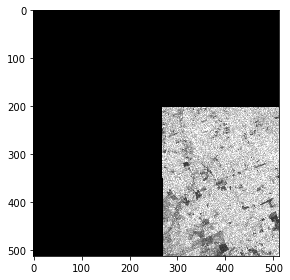

In [11]:
skio.imshow(tiled_arr[0,0,:,:])

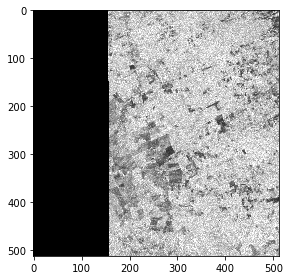

In [13]:
skio.imshow(arr[0:512,0:512])

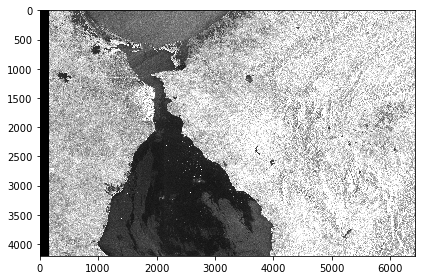

In [12]:
skio.imshow(arr)

In [ ]:
image_id = 1
segmentation_id = 1

images_d = []

# filter for jpeg images
for i,n in enumerate(chps):
    images_d.append({"file_name": str(n), "height": 512, "width": 512, "id":i})

    # go through each label image to extract annotation
    image = Image.open(str(n))
    image_info = pycococreatortools.create_image_info(
        image_id, os.path.basename(str(n)), image.size)
    coco_output["images"].append(image_info)

    annotation_filename = str(lbl_chps[i])
    arr = np.array(Image.open(annotation_filename))
    if 1 in arr:
        class_id = 1
        category_info = {"id":class_id,"is_crowd":True} # forces compressed RLE format
    else:
        class_id = 0
        category_info = {"id":class_id,"is_crowd":False}
    binary_mask = np.asarray(Image.open(annotation_filename)).astype(np.uint8)

    annotation_info = pycococreatortools.create_annotation_info(
        segmentation_id, image_id, category_info, binary_mask,
        image.size, tolerance=0)

    if annotation_info is not None:
        coco_output["annotations"].append(annotation_info)

    segmentation_id = segmentation_id + 1

    image_id = image_id + 1

with open('{}/instances_slick_train.json'.format(path), 'w') as output_json_file:
    json.dump(coco_output, output_json_file)

In [ ]:
class_map = ClassMap(["oil_slick"])
class_map # https://airctic.github.io/icedata/dataset_voc_nb/#define-class_map

In [ ]:
parser = parsers.COCOMaskParser(f'{path}/instances_slick_train.json', img_dir)

### Parsing works! we're just trying to test if this trains and evaluates correctly, it's ok if many of these instances don't look like instances for now since the dataset was made for semantic segmentation

It's possible icevision is filtering out all negative samples here during autofixing, which we can check. Our most useful samples will include non-background class hard negatives and positives anyway

In [ ]:
# Parse the annotations to create the train and validation records
train_records, valid_records = parser.parse()
x=show_records(train_records[:3], ncols=3, class_map=class_map)
plt.savefig("train_slick_examples.png")

Normalizing is best practice and necessary for icevision to propoerly display predicition results

In [ ]:
train_tfms = tfms.A.Adapter(
    [
        tfms.A.Normalize(),
    ]
)

In [ ]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=512), tfms.A.Normalize()])

sourced from: https://airctic.com/0.8.1/getting_started_instance_segmentation/

In [ ]:
train_ds.records.autofix??

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=6, shuffle=True) # adjust num_workers for your processor count
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=6, shuffle=False)

model = model_type.model(backbone=backbone(pretrained=False), num_classes=len(parser.class_map))

metrics = [COCOMetric(metric_type=COCOMetricType.mask, print_summary=False)]

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

lr = learn.lr_find()

In [ ]:
lr

The suggested learning rate makes getting to higher confidence predictions take too long. We picked the learning rate arbitrarily below to speed up getting to losses closer to .5 instead of greater than 1. 

In [ ]:
learn.fine_tune(30,2.511886486900039e-03)

a TODO is to debug the COCOMetric, it should not be -1 given that we are now acheiving detections that intersect with groundtruth.

In [ ]:
print(f"approximate time to train 30 epochs in minutes: {25*30/60}")


The predictions above .7 confidence that roughly line up with groundtruth demonstrates that icevision-trained models can produce predictions that look like they are headed in the correct direction, even for an imperfect training set.

In [ ]:
model_type.show_results??

In [ ]:
x = model_type.show_results(model, valid_ds, detection_threshold=.6)
plt.savefig("inference_results.png")

In [ ]:
show_results??